In [105]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sklearn.datasets
import IPython.display
import pickle

# Graph

In [271]:
def grid100():
    return nx.generators.lattice.grid_2d_graph(10,10)

def er100():
    return nx.generators.erdos_renyi_graph(directed=False,n=100,p=6/99)

[[ 5. -1.  0. ...  0.  0.  0.]
 [-1.  5.  0. ...  0.  0.  0.]
 [ 0.  0.  4. ... -1.  0.  0.]
 ...
 [ 0.  0. -1. ...  5.  0. -1.]
 [ 0.  0.  0. ...  0.  6.  0.]
 [ 0.  0.  0. ... -1.  0.  4.]] 17.880249094732278


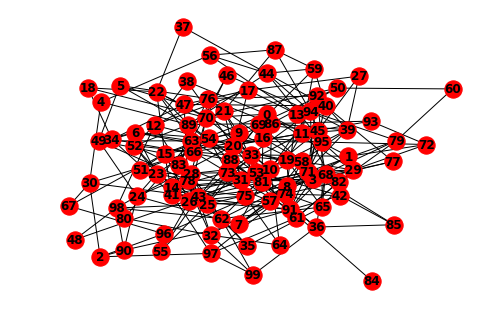

In [272]:
g = er100()
nx.draw(g, with_labels=True, font_weight='bold')#,pos = nx.drawing.layout.random_layout(g))


def get_laplacian(graph):
    assert nx.is_connected(graph)
    lap = np.array(nx.laplacian_matrix(g).todense(), dtype='float64')
    spectrum = nx.laplacian_spectrum(g)
    assert np.allclose(lap.T, lap)
    return lap, spectrum[-1] / spectrum[1]

W, χ = get_laplacian(g)

print(W, χ)

## Chebyshev Acceleration

In [273]:
def chebyshev(x, i):
    assert x.shape[0] == x.shape[1]
    assert i >= 0
    n = x.shape[0]
    if i == 0:
        return np.eye(n)
    if i == 1:
        return x
    
    p_1 = np.eye(n)
    p_2 = x
    
    for l in range(1,i):
        p_new =  2. * x@p_2 - p_1
        p_1 = p_2
        p_2 = p_new
        
    return p_2

chebyshev_steps = int(np.sqrt(χ))

c = (χ + 1.) / (χ - 1.)

norm_W = W *2. * χ / (1. + χ) / np.linalg.eigvalsh(W)[-1]

opt_W = np.eye(100) -  chebyshev(c * (np.eye(100) - norm_W),chebyshev_steps) / chebyshev(np.array([[c]]),chebyshev_steps)[0][0]
#print(opt_W)
print(np.linalg.eigvalsh(opt_W)[0],np.linalg.eigvalsh(opt_W)[1],
      np.linalg.eigvalsh(opt_W)[-1] / np.linalg.eigvalsh(opt_W)[1], chebyshev_steps)

-8.881784197001252e-16 0.7152638083099735 1.7961012971607009 4


# Data

In [254]:
class Oracle:
    def __init__(self, A_, b_, reg_):
        self.A = [A_[i * 100: (i+1)*100] for i in range(0,100)]
        self.b = [b_[i * 100: (i+1)*100] for i in range(0,100)]
        self.μ = reg_
        self.L = [np.linalg.norm(self.A[i], ord=2) ** 2 / self.A[i].shape[0] for i in range(0,100)]
#         print(self.L[0])
#         print(np.linalg.eigvalsh(self.A[0] @self.A[0].T))
        self.L = np.max(self.L)/4. + reg_
        self.d = A_.shape[1]
        print("Logistic regression oracle created")
        print("\td = {},L = {}; μ = {}".format(self.d,self.L, self.μ))
        print("\tκ = {}".format(self.L / self.μ))
        
        
    def f_i(self,x,i):
        return np.average(np.log(1. + np.exp(-self.b[i] * np.dot(self.A[i],x)))) + 0.5 * self.μ * x.dot(x)
    
    def grad_i(self,x,i):
        return self.A[i].T.dot(-self.b[i] / (1. + np.exp(self.b[i] * np.dot(self.A[i],x)))) / 100. + self.μ * x
    
    def f(self,x):
        return np.average([self.f_i(x,i) for i in range(100)])
    
    def grad(self,x):
        return np.average([self.grad_i(x,i) for i in range(100)],axis=0)
    
    def dist_grad(self,x):
        g = []
        for i in range(len(x)):
            g.append(self.grad_i(x[i], i))
        return np.array(g)

In [255]:
def prepare_dataset():
    perm = np.random.permutation(10000)
    A, b = sklearn.datasets.load_svmlight_file('data/a6a.txt')
    A = np.array(A.todense())
    
    while (A.shape[0] < 10000):
        A = np.concatenate([A,A],axis=0)
        b = np.concatenate([b,b],axis=0)
    
    A = A[perm]
    b = np.array(b[perm])
    return A,b
    
# A, b = prepare_dataset()
A, b = sklearn.datasets.make_classification(n_samples=10000, n_features=100)
print(A.shape,b.shape)


(10000, 100) (10000,)


In [257]:
oracle = Oracle(A,b,2.e-3)

Logistic regression oracle created
	d = 100,L = 2.089760610047173; μ = 0.002
	κ = 1044.8803050235863


# GD and AGD for to find $x^*$

In [274]:
def agd(oracle, x_0, x_star = None):
    y_k = np.copy(x_0)
    z_k = np.copy(x_0)
    α = np.sqrt(oracle.μ / oracle.L)
    
    plot = {'f' : [], 'grad_norm_sqr' : [], 'dist':[]}
    if x_star is not None:
        dist_0 = np.linalg.norm(x_0 - x_star,ord=2)**2
    
    for k in range(4000):
        x_k = α * z_k + (1. - α) * y_k
        g_k = oracle.grad(x_k)
        z_new = (z_k + x_k * α - g_k / (α * oracle.L)) / (1.+α)
        y_k = x_k + α * (z_new - z_k) 
        z_k = z_new
        
        plot['f'].append(oracle.f(y_k))
        plot['grad_norm_sqr'].append(np.linalg.norm(oracle.grad(y_k),ord=2)**2)
        if x_star is not None:
            plot['dist'].append(np.linalg.norm(y_k - x_star,ord=2)**2 / dist_0)
            
        
    return plot, y_k
        
plot_agd, x_star = agd(oracle, np.random.randn(oracle.d), None)        
#plot_agd, x_star = agd(oracle, np.random.randn(oracle.d), x_star)

In [275]:
def gd(oracle, x_0, x_star):
    x_k = np.copy(x_0)
    plot = {'f' : [], 'grad_norm_sqr' : [], 'dist' : []}
    
    dist_0 = np.linalg.norm(x_k - x_star,ord=2)**2
    
    for k in range(1000):
    
        x_k -= oracle.grad(x_k) / oracle.L
        
        plot['f'].append(oracle.f(x_k))
        plot['grad_norm_sqr'].append(np.linalg.norm(oracle.grad(x_k),ord=2)**2)
        plot['dist'].append(np.linalg.norm(x_k - x_star,ord=2)**2 / dist_0)
        
    return plot, x_k
        
        
plot_gd, _ = gd(oracle, np.random.randn(oracle.d), x_star)

(0, 2000)

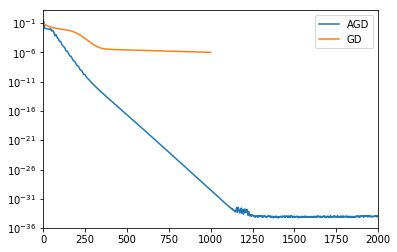

In [276]:
plt.plot(plot_agd['grad_norm_sqr'],label='AGD')
plt.plot(plot_gd['grad_norm_sqr'], label='GD')
plt.legend()
plt.yscale('log')
plt.xlim(0,2000)

# Decentralized experiments

In [277]:
def distance(x, x_star):
    norm = np.linalg.norm(x-x_star, ord=2,axis=1)
    return np.max(norm) ** 2.

## Louris-Verhoven 

In [278]:
def ALV(oracle, W, comm_per_iter, x_0, x_star, max_iter):
    
    y_k = np.zeros_like(x_0)
    x_k = np.copy(x_0)
    x_fk = np.copy(x_0)
    
    χ = np.linalg.eigvalsh(W)[-1] / np.linalg.eigvalsh(W)[1]
    κ = oracle.L / oracle.μ
    τ = np.min([1., 0.5 * np.sqrt(χ / κ)])
    η = 1. / (4. * τ * oracle.L)
    θ = 1. / (η * np.linalg.eigvalsh(W)[-1])
    α = oracle.μ
    
    plot = {'dist':[1.],'grad_eval':[0],'comm':[0]}
    
    
    dist_0 = distance(x_fk,x_star)
    
    for k in range(max_iter):
        x_gk = τ * x_k + (1.-τ) * x_fk
        
        g_k = oracle.dist_grad(x_gk)
        
        x_new = (x_k - η * g_k + η*α*x_gk - η * y_k) / (1. + η * α)
        
        y_k = y_k + θ * W @ x_new
        
        x_new = (x_k - η * g_k + η*α*x_gk - η * y_k) / (1. + η * α)
        
        x_fk = x_gk + 2.*τ/(2.-τ) * (x_new - x_k)      
        x_k = x_new
        
        
        plot['dist'].append(distance(x_fk,x_star) / dist_0)
        plot['grad_eval'].append(k + 1)
        plot['comm'].append((k + 1) * comm_per_iter)
    return plot

In [279]:
plot_alv = ALV(oracle, W, 1, np.random.randn(100,oracle.d), x_star, 8000)

In [280]:
plot_alv_opt = ALV(oracle, opt_W, chebyshev_steps, np.random.randn(100,oracle.d), x_star, 4000)

## Accelerated Penalty

In [281]:
def APM(oracle, x_0, x_star):
    y_k = np.copy(x_0)
    z_k = np.copy(x_0)
    α = np.sqrt(oracle.μ / oracle.L)
    λ_max = np.linalg.eigvalsh(W)[-1]
    
    σ_2 = 1 - 1/χ
    η = (1. - np.sqrt(1.-σ_2**2)) / (1. + np.sqrt(1.-σ_2**2))
    
    C = np.sqrt(χ) * np.sqrt(oracle.μ / oracle.L)
    print(C)
    
    plot = {'dist':[1.],'grad_eval':[0],'comm':[0]}
    
    dist_0 = distance(y_k,x_star)
    
    for k in range(1000):
        x_k = α * z_k + (1. - α) * y_k
        
        g_k = oracle.dist_grad(x_k)
        z_new = (z_k + x_k * α - g_k / (α * oracle.L)) / (1.+α)
        
        z_2 = np.copy(z_new)
        z_1 = np.copy(z_new)
        
        T = int(C * k) + 2
        for t in range(T):
            z_new = (1 + η) * (z_2 - W @ z_2 / λ_max) - η * z_1
            z_1 = z_2
            z_2 = z_new
        
        
        
        
        z_new = z_2
        y_k = x_k + α * (z_new - z_k)
        z_k = z_new
        
        plot['dist'].append(distance(y_k,x_star) / dist_0)
        plot['grad_eval'].append(k + 1)
        plot['comm'].append(plot['comm'][-1] + T)
        

            
        
    return plot

plot_apm = APM(oracle, np.random.randn(100,oracle.d), x_star)

0.13081378468196028


## Catalyst + Extra

In [282]:
def extra(oracle, τ, y, max_iter, x_0, v_0, plot, x_star, dist_0):
    x_k = np.copy(x_0)
    v_k = np.copy(v_0)
    
    β = oracle.L + τ
    α = 1. / (4. * β)  
    
    λ_max = np.linalg.eigvalsh(W)[-1]
    
    for k in range(max_iter):
        g_k = oracle.dist_grad(x_k) + τ * (x_k - y)
        
        x_k = x_k - α * (g_k + v_k + 0.5 * β / λ_max * W @ x_k)
        v_k = v_k + 0.5 * β / λ_max * W @ x_k
        
        plot['dist'].append(distance(x_k,x_star) / dist_0)
        plot['grad_eval'].append(plot['grad_eval'][-1] + 1)
        plot['comm'].append(plot['comm'][-1] + 1)
        
    return x_k, v_k

def catalyst(oracle, x_0, x_star):
    plot = {'dist':[1.],'grad_eval':[0],'comm':[0]}
    dist_0 = distance(x_0,x_star)
    
    
    x_k = np.copy(x_0)
    y_k = np.copy(x_0)
    v_k = np.zeros_like(x_0)
     
    τ = oracle.L / χ - oracle.μ
    assert τ > 0
    print('τ = {}'.format(τ))
    
    q = oracle.μ / (oracle.μ + τ)
    θ = np.sqrt(q)
    T = int(0.2 * χ * np.log(χ * oracle.L / oracle.μ)) + 1
    print('T = {}'.format(T))
    
    for k in range(400):
        
        x_new, v_new = extra(oracle, τ, y_k, T, x_k, v_k, plot, x_star, dist_0)
        
        y_k = x_new + ((1. - θ) / (1. + θ)) * (x_new - x_k)
        x_k = x_new
        v_k = v_new
    
    return plot
    
plot_cat = catalyst(oracle, np.random.randn(100,oracle.d), x_star)

τ = 0.11487536336743986
T = 36


## MSDA

In [283]:
def dual_grad(oracle, z, g_0, eps, T_max):
    
    y_k = np.copy(g_0)
    z_k = np.copy(y_k)
    
    
    κ = oracle.L / oracle.μ
    α = 1. / np.sqrt(κ)
    k = 0
    while True:
        x_k = α * z_k + (1. - α) * y_k
        g_k = oracle.dist_grad(x_k) - z
        z_new = (z_k + α * x_k - g_k / (α * oracle.L)) / (1. + α)
        y_k = x_k + α * (z_new - z_k)
        z_k = z_new
        
        k+=1
    
#         if (distance(oracle.dist_grad(x_k), z) < eps):
#             break;
            
        if (k >= T_max):
            break;
        
    return y_k, k
    



def MSDA(oracle, x_0, x_star):
    
    
    
    y_k = np.zeros_like(x_0)
    z_k = np.zeros_like(x_0)
    g_k = np.zeros_like(x_0)
    
    plot = {'dist':[1.],'grad_eval':[0],'comm':[0]}
    dist_0 = distance(g_k,x_star)
    
    
    χ = np.linalg.eigvalsh(opt_W)[-1] / np.linalg.eigvalsh(opt_W)[1]
    λ_max = np.linalg.eigvalsh(opt_W)[-1]
    κ = oracle.L / oracle.μ
    α = 1. / np.sqrt(χ * κ)
    
    
    for k in range(600):
        
        
        x_k = α * z_k + (1. - α) * y_k
        g_k, T = dual_grad(oracle, x_k, np.copy(g_k), 1e-12, 60)
        z_new = (z_k + α * x_k - opt_W @ g_k / (α * λ_max / oracle.μ)) / (1. + α)
        y_k = x_k + α * (z_new - z_k)
        z_k = z_new
        
        plot['dist'].append(distance(g_k,x_star) / dist_0)
        plot['grad_eval'].append(plot['grad_eval'][-1] + T)
        plot['comm'].append(plot['comm'][-1] + chebyshev_steps)
        print(k,T,distance(g_k,x_star) / dist_0)
        
    return plot 
    
plot_msda = MSDA(oracle, np.random.randn(100,oracle.d), x_star)

0 60 20.341228262939943
1 60 5.334638180763958
2 60 5.061168608084579
3 60 4.5188798778895185
4 60 3.368595861135852
5 60 2.406394916953098
6 60 1.9240830646447293
7 60 1.3788010971321618
8 60 1.0784937104071424
9 60 1.7752055322521119
10 60 6.533419889924109
11 60 7.9032891030581185
12 60 8.535223702945851
13 60 7.167178331634165
14 60 6.850773112772055
15 60 4.857016269568348
16 60 3.9944494665678003
17 60 3.9941981844001777
18 60 4.242897349315557
19 60 4.263700585666054
20 60 5.058837196732666
21 60 3.289160769021322
22 60 2.0797357906027183
23 60 1.5587815854062235
24 60 1.4965363585181548
25 60 1.5224009699862249
26 60 1.0861990674829305
27 60 1.6035544326688487
28 60 1.0682619415357018
29 60 0.7300076980741791
30 60 0.6095539496929139
31 60 0.5726605436545564
32 60 0.5012503483816304
33 60 0.6232101532258483
34 60 0.7153019823242709
35 60 0.47203171732203286
36 60 0.27344483280939064
37 60 0.3429003483892067
38 60 0.45492698256095804
39 60 0.4482919432146781
40 60 0.269440828163

292 60 1.4112277515086873e-07
293 60 1.2945363070839133e-07
294 60 1.1854343811973354e-07
295 60 1.0843266722593356e-07
296 60 1.041996334048831e-07
297 60 1.0408928524048924e-07
298 60 1.0390671819098055e-07
299 60 1.0358136061829911e-07
300 60 1.0305300687167447e-07
301 60 1.0227186855369842e-07
302 60 1.0119857097553893e-07
303 60 9.980422852819532e-08
304 60 9.807050934192291e-08
305 60 9.598947666988516e-08
306 60 9.35630821713203e-08
307 60 9.080237080216506e-08
308 60 8.77265550400708e-08
309 60 8.436206543287768e-08
310 60 8.074156595126385e-08
311 60 7.690286098396201e-08
312 60 7.288767102352937e-08
313 60 6.874035363431228e-08
314 60 6.450668449226659e-08
315 60 6.023275320145698e-08
316 60 5.5963940492313176e-08
317 60 5.17439192000259e-08
318 60 4.761367945499312e-08
319 60 4.361065563670363e-08
320 60 3.976805274133622e-08
321 60 3.8552442614440217e-08
322 60 3.7299966672346986e-08
323 60 3.5957731266899453e-08
324 60 3.454059539255296e-08
325 60 3.30645167588849e-08
326 

573 60 1.0428576411987497e-13
574 60 9.715411735080076e-14
575 60 9.022138160612887e-14
576 60 8.511823576837582e-14
577 60 8.26799598256891e-14
578 60 8.016060781678064e-14
579 60 7.757557154014003e-14
580 60 7.493946647454533e-14
581 60 7.226582892476785e-14
582 60 6.956693030580487e-14
583 60 6.685369459945698e-14
584 60 6.470657782832927e-14
585 60 6.387359591279811e-14
586 60 6.291694513096958e-14
587 60 6.183661120491389e-14
588 60 6.063498636374807e-14
589 60 5.931654576143341e-14
590 60 5.788753801655647e-14
591 60 5.635569008666814e-14
592 60 5.472992790532236e-14
593 60 5.302011433490196e-14
594 60 5.123680474984547e-14
595 60 4.9391021420860787e-14
596 60 4.749404723398052e-14
597 60 4.555723915957377e-14
598 60 4.359186172542873e-14
599 60 4.160894037642715e-14


# Results

In [284]:
pickle.dump({'alv_opt' : plot_alv_opt,
             'alv' : plot_alv,
             'apm' : plot_apm,
             'cat' : plot_cat,
             'msda' : plot_msda}, open('dump/er_d=100','xb'))

## Gradient Complexity

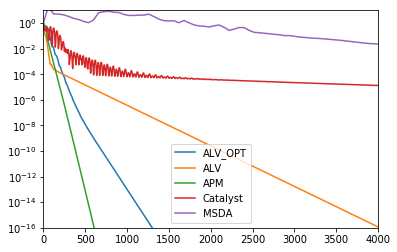

In [285]:
plt.plot(plot_alv_opt['grad_eval'],plot_alv_opt['dist'], label='ALV_OPT')
plt.plot(plot_alv['grad_eval'],plot_alv['dist'], label='ALV')
plt.plot(plot_apm['grad_eval'],plot_apm['dist'], label='APM')
plt.plot(plot_cat['grad_eval'],plot_cat['dist'], label='Catalyst')
plt.plot(plot_msda['grad_eval'],plot_msda['dist'], label='MSDA')

plt.legend()
plt.yscale('log')
plt.xlim(0,4000)
plt.ylim(1e-16,10.)
plt.savefig(('gradient.pdf'))

## Communication Complexity

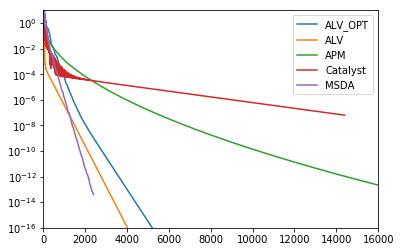

In [286]:
plt.plot(plot_alv_opt['comm'],plot_alv_opt['dist'], label='ALV_OPT')
plt.plot(plot_alv['comm'],plot_alv['dist'], label='ALV')
plt.plot(plot_apm['comm'],plot_apm['dist'], label='APM')
plt.plot(plot_cat['comm'],plot_cat['dist'], label='Catalyst')
plt.plot(plot_msda['comm'],plot_msda['dist'], label='MSDA')

plt.legend()
plt.yscale('log')
plt.xlim(0,16000)
plt.ylim(1e-16,10.)
plt.savefig(('communication.pdf'))